In [1]:
# Build an emulator based on data from all basins
# Investigate different emulator set up and methods
# spatial CV

In [2]:

import sys, os, glob, pickle, toml, json
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

sys.path.append("../../MOASMO_support")
from MOASMO_parameters import *

sys.path.append("/glade/u/home/guoqiang/CTSM_repos/ctsm_optz/MO-ASMO/src")
import NSGA2


def get_modified_KGE(obs,sim):
    ind = (~np.isnan(obs)) & (~np.isnan(sim))
    obs = obs[ind]
    sim = sim[ind]

    try:
        sd_sim=np.std(sim, ddof=1)
        sd_obs=np.std(obs, ddof=1)
        m_sim=np.mean(sim)
        m_obs=np.mean(obs)
        r=(np.corrcoef(sim,obs))[0,1]
        relvar=(float(sd_sim)/float(m_sim))/(float(sd_obs)/float(m_obs))
        bias=float(m_sim)/float(m_obs)
        kge=1.0-np.sqrt((r-1)**2 +(relvar-1)**2 + (bias-1)**2)
    except:
        kge = np.nan

    return kge, r, bias, relvar

In [3]:
ncpus = 10 # used for model train (RF can use all cpus; BP-NN can only use 5 for 5-fold cross validation)

# Load data for all basins
From step-1 script

In [4]:
file = 'camels_627basin_allinfo.pkl'

if os.path.exists(file):
    # Load dataframes from the outfile
    with pd.HDFStore(file, 'r') as store:
        df_basin_info = store['df_basin_info']
        df_param_info = store['df_param_info']
        df_att = store['df_att']
else:
    print('File does not exist')

# print('df_basin_info')
# display(df_basin_info.iloc[[0]])

# print('df_param_info')
# display(df_param_info.iloc[[0]])

# print('df_att')
# display(df_att.iloc[[0]])

In [5]:
# model outputs
inpath_moasmo = "/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange"

file_defa_param = 'camels_627basin_ctsm_defa_param.csv'
if os.path.isfile(file_defa_param):
    df_param_defa = pd.read_csv(file_defa_param)
else:
    print('file_defa_param does not exist')

file_all_param = 'camels_627basin_ctsm_all_param.csv.gz'
if os.path.isfile(file_all_param):
    df_param = pd.read_csv(file_all_param, compression='gzip')
else:
    print('file_all_param does not exist')

file_all_metric = 'camels_627basin_ctsm_all_metric.csv.gz'
file_all_basinid = 'camels_627basin_ctsm_all_basinid.csv.gz'

if os.path.isfile(file_all_param):
    df_metric = pd.read_csv(file_all_metric, compression='gzip')
    df_basinid = pd.read_csv(file_all_basinid, compression='gzip')
else:
    print('file_all_param does not exist')

# remove nan values (some failed models)
index = np.isnan(np.sum(df_metric.values, axis=1))
df_param = df_param[~index]
df_metric = df_metric[~index]
df_basinid = df_basinid[~index]

df_param.index = np.arange(len(df_param))
df_metric.index = np.arange(len(df_metric))
df_basinid.index = np.arange(len(df_basinid))

print('Number of nan samples:', np.sum(index))
print("Number of original parameter sets:", len(index))
print("Number of final parameter sets:", len(df_param))

Number of nan samples: 3309
Number of original parameter sets: 250800
Number of final parameter sets: 247491


In [6]:
# Load attributes for training
attlist = toml.load('camels_attributes_fortrain.toml')
att_Xie2021 = attlist['att_Xie2021']

useattrs = list(att_Xie2021.keys())
print("The number of attributes used:", len(useattrs))
print(useattrs)

The number of attributes used: 27
['p_mean', 'pet_mean', 'aridity', 'p_seasonality', 'frac_snow', 'high_prec_freq', 'high_prec_dur', 'low_prec_freq', 'low_prec_dur', 'mean_elev', 'mean_slope', 'area_gauges2', 'frac_forest', 'lai_max', 'lai_diff', 'dom_land_cover_frac', 'dom_land_cover', 'soil_depth_pelletier', 'soil_depth_statsgo', 'soil_porosity', 'soil_conductivity', 'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac', 'carbonate_rocks_frac', 'geol_permeability']


# create model inputs and outputs 
parameters + attributes -> obj funcs

In [7]:
# Prepare model input and output

df_input = df_param.copy()
df_input["hru_id"] = df_basinid["hru_id"]
df_input = df_input.merge(df_att[useattrs + ["hru_id"]], on="hru_id", how="left")
df_input = df_input.drop(["hru_id"], axis=1)

inputnames = list(df_param.columns) + useattrs
# print("Input parameters:", list(df_param.columns))
# print("Input attribuets:",  useattrs)

# if there is string attributes in the input, convert them to one-hot encoding
for att in useattrs:
    if df_input[att].dtype == "object":
        print('convert', att, 'to one-hot encoding')
        enc = OneHotEncoder(sparse=False)
        enc.fit(df_input[[att]])
        encnames = [att + "_" + str(i) for i in range(len(enc.categories_[0]))]
        print('new columns:', encnames)
        df_enc = pd.DataFrame(enc.transform(df_input[[att]]), columns=encnames)
        df_input = pd.concat([df_input, df_enc], axis=1)
        df_input = df_input.drop([att], axis=1)
        inputnames = [i for i in inputnames if i != att] + encnames


# convert to numpy array for training / testing
# print("Input parameters after adjustment:", list(df_param.columns))
# print("Input attribuets after adjustment:",  useattrs)

x_all = df_input[inputnames].values.copy()
print("Input shape:", x_all.shape)

convert dom_land_cover to one-hot encoding
new columns: ['dom_land_cover_0', 'dom_land_cover_1', 'dom_land_cover_2', 'dom_land_cover_3', 'dom_land_cover_4', 'dom_land_cover_5', 'dom_land_cover_6', 'dom_land_cover_7', 'dom_land_cover_8', 'dom_land_cover_9', 'dom_land_cover_10', 'dom_land_cover_11']
Input shape: (247491, 65)


In [8]:
# check what metrics to be used as optimzation targets

# fig = plt.figure(figsize=[10, 4])

# flag = 1
# for i in ['kge', 'mae', 'n_mae', 'nse', 'cc', 'rmse', 'max_mon_abs_err', 'n_max_mon_abs_err',  'kge_log_q']:
#     fig.add_subplot(3, 3, flag)
#     flag = flag + 1
#     plt.plot(df_metric[i].values)
#     plt.title(i)
    
# plt.tight_layout()
# plt.show()

# plt.hist(df_output[["rmse"]].values)
# plt.hist(df_output[["kge"]].values, np.arange(-10, 1, 0.01))

## Outputs

In [9]:
# use normalized kge as output

df_output = df_metric.copy()
y_all = df_output[["kge"]].values.copy()
y_all = y_all / (2 - y_all) # normalize KGE

print("Output shape:", y_all.shape)

Output shape: (247491, 1)


# Train / Test emulators

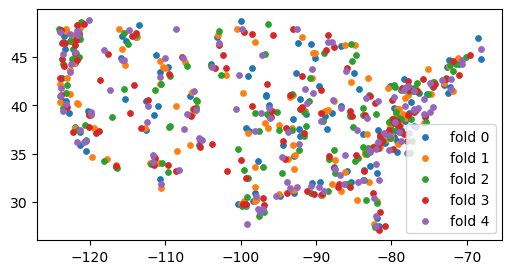

In [10]:
def get_cv_indices(df_basinid, nfold=5):
    from sklearn.model_selection import GroupKFold

    # Initialize GroupKFold
    group_kfold = GroupKFold(n_splits=nfold)

    # Dictionary to store train and test indices
    cv_indices = {}

    # Cross-validation process to save indices
    # does not depend on random seeds
    for fold, (train_index, test_index) in enumerate(group_kfold.split(df_basinid, groups=df_basinid['basin_num'])):
        
        train_basin = np.unique(df_basinid.iloc[train_index]['basin_id'].values)
        test_basin = np.unique(df_basinid.iloc[test_index]['basin_id'].values)

        cv_indices[fold] = {'train_index': train_index, 'test_index': test_index, 'train_basin': train_basin, 'test_basin': test_basin} 
    return cv_indices

# Get the indices
nfold = 5
cv_indices = get_cv_indices(df_basinid, nfold)

# plot test basin batches
fig = plt.figure(figsize=(6, 3))
for fold in range(len(cv_indices)):
    test_basin = cv_indices[fold]['test_basin']
    lat = df_basin_info.iloc[test_basin]['lat_cen'].values
    lon = df_basin_info.iloc[test_basin]['lon_cen'].values
    plt.scatter(lon, lat, 15, label=f'fold {fold}')

plt.legend()
plt.show()

## Random forest hyperparameter comparison

In [11]:
from sklearn.ensemble import RandomForestRegressor


def get_rmse(d1, d2):
    return ( np.nanmean( (d1-d2)**2 ) ) ** 0.5

def rf_run_cross_validation_parallel(cv_indices, x_all, y_all, ncpus, samplestep, modelconfig={'n_estimators': 100, 'random_state': 42}):

    if True:

        rf_cv_results = {}
        
        # Cross-validation loop
        for fold, indices in cv_indices.items():
        
            # print(f"RF Fold {fold}")
        
            train_index = indices['train_index'][::samplestep]
            test_index = indices['test_index']
            
            x_train, x_test = x_all[train_index], x_all[test_index]
            y_train, y_test = y_all[train_index], y_all[test_index]
            
            # Initialize a new RandomForestRegressor for each fold
            rf_model = RandomForestRegressor(**modelconfig, n_jobs=ncpus)
            
            # Train the model
            rf_model.fit(x_train, y_train)
        
            # Predict on the test set
            y_test_pred = rf_model.predict(x_test)
            y_train_pred = rf_model.predict(x_train)

            if y_test_pred.ndim == 1 and y_test.ndim == 2:
                y_test_pred = y_test_pred[:, np.newaxis]
                y_train_pred = y_train_pred[:, np.newaxis]
            
            
            # Store results
            rf_cv_results[fold] = {
                # 'model': rf_model,
                'train_index': train_index,
                'test_index': test_index,
                'y_train': y_train,
                'y_test': y_test,
                'y_test_pred': y_test_pred,
                'y_train_pred': y_train_pred,
            }
        
    return rf_cv_results


def evaluate_cv_kge(cv_results):
    # evaluation
    kge_test = np.nan * np.zeros([len(cv_results), cv_results[0]['y_train'].shape[1], 4]) #  kge, r, bias, relvar
    kge_train = np.nan * np.zeros([len(cv_results), cv_results[0]['y_train'].shape[1], 4])
    
    for fold in range(len(cv_results)):
        y_train, y_test, y_train_pred, y_test_pred = cv_results[fold]['y_train'], cv_results[fold]['y_test'], cv_results[fold]['y_train_pred'], cv_results[fold]['y_test_pred']
        
        # Evaluate the model using KGE
        for i in range(y_all.shape[1]):
            kge_test[fold - 1, i, :] = get_modified_KGE(y_test[:, i], y_test_pred[:, i])
            kge_train[fold - 1, i, :] = get_modified_KGE(y_train[:, i], y_train_pred[:, i])
    
    for i in [2, 3]:
        kge_test[:,:,i] = kge_test[:,:,i] - 1 # relative bias centering at 0
        kge_train[:,:,i] = kge_train[:,:,i] - 1

    return kge_test, kge_train


def evaluate_cv_rmse(cv_results):
    # evaluation
    rmse_test = np.nan * np.zeros([len(cv_results), cv_results[0]['y_train'].shape[1]])
    rmse_train = np.nan * np.zeros([len(cv_results), cv_results[0]['y_train'].shape[1]])
    
    for fold in range(len(cv_results)):
        y_train, y_test, y_train_pred, y_test_pred = cv_results[fold]['y_train'], cv_results[fold]['y_test'], cv_results[fold]['y_train_pred'], cv_results[fold]['y_test_pred']
        
        # Evaluate the model using 
        for i in range(y_all.shape[1]):
            rmse_test[fold - 1, i] = get_rmse(y_test[:, i], y_test_pred[:, i])
            rmse_train[fold - 1, i] = get_rmse(y_train[:, i], y_train_pred[:, i])
            
    return rmse_test, rmse_train

def load_existing_results(outfile):
    if os.path.exists(outfile):
        with open(outfile, 'r') as file:
            results = json.load(file)
    else:
        results = {}
    return results

def save_results(outfile, results):
    with open(outfile, 'w') as file:
        json.dump(results, file, indent=4)

def config_exists(results, config):
    config_str = json.dumps(config, sort_keys=True)
    return config_str in results

def add_result(results, config, train_rmse, test_rmse):
    config_str = json.dumps(config, sort_keys=True)
    results[config_str] = {
        "train_rmse": train_rmse.tolist(),
        "test_rmse": test_rmse.tolist()
    }

In [23]:
%%time

outfile = 'rf_cv_hyperparameter_objfunc_normKGE.json'

# Load existing results
results = load_existing_results(outfile)

# Model configurations
modelconfigs = [
    {'n_estimators': 50, 'random_state': 42, 'max_depth': None},
    {'n_estimators': 100, 'random_state': 42, 'max_depth': None},
    {'n_estimators': 100, 'random_state': 42, 'max_depth': 2},
    {'n_estimators': 100, 'random_state': 42, 'max_depth': 5},
    {'n_estimators': 100, 'random_state': 42, 'max_depth': 10},
    {'n_estimators': 100, 'random_state': 42, 'max_depth': 20},
    {'n_estimators': 100, 'random_state': 42, 'max_depth': 40},
    {'n_estimators': 100, 'random_state': 42, 'max_depth': 60},
    {'n_estimators': 200, 'random_state': 42, 'max_depth': None},
    {'n_estimators': 200, 'random_state': 42, 'max_depth': 10},
    {'n_estimators': 200, 'random_state': 42, 'max_depth': 20},
]

samplestep = 5
for modelconfig in modelconfigs:
    if not config_exists(results, modelconfig):
        rf_cv_results = rf_run_cross_validation_parallel(cv_indices, x_all, y_all, ncpus, samplestep, modelconfig)
        rf_rmse_test, rf_rmse_train = evaluate_cv_rmse(rf_cv_results)

        print(modelconfig)
        print(np.nanmean(rf_rmse_train, axis=0))
        print(np.nanmean(rf_rmse_test, axis=0))

        add_result(results, modelconfig, np.nanmean(rf_rmse_train, axis=0), np.nanmean(rf_rmse_test, axis=0))
    else:
        print(f"Configuration {modelconfig} already exists in the results file.")

# Save updated results
save_results(outfile, results)

for i, j in results.items():
    print(i, j)

Configuration {'n_estimators': 50, 'random_state': 42, 'max_depth': None} already exists in the results file.
Configuration {'n_estimators': 100, 'random_state': 42, 'max_depth': None} already exists in the results file.
Configuration {'n_estimators': 100, 'random_state': 42, 'max_depth': 2} already exists in the results file.
Configuration {'n_estimators': 100, 'random_state': 42, 'max_depth': 5} already exists in the results file.
Configuration {'n_estimators': 100, 'random_state': 42, 'max_depth': 10} already exists in the results file.
Configuration {'n_estimators': 100, 'random_state': 42, 'max_depth': 20} already exists in the results file.
Configuration {'n_estimators': 100, 'random_state': 42, 'max_depth': 40} already exists in the results file.
Configuration {'n_estimators': 100, 'random_state': 42, 'max_depth': 60} already exists in the results file.
Configuration {'n_estimators': 200, 'random_state': 42, 'max_depth': None} already exists in the results file.
Configuration {'

## BP NN hyperparameter comparison

In [24]:
from multiprocessing import Pool, cpu_count
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor


def bpnn_run_cross_validation_serial(cv_indices, x_all, y_all, ncpus, outfile):
    if os.path.isfile(outfile):
        with open(outfile, 'rb') as file:
            ann_cv_results = pickle.load(file)
    else:
        ann_cv_results = {}
        
        # Cross-validation loop
        for fold, indices in cv_indices.items():
        
            print(f"BP Fold {fold}")
        
            train_index = indices['train_index']
            test_index = indices['test_index']
            
            x_train, x_test = x_all[train_index], x_all[test_index]
            y_train, y_test = y_all[train_index], y_all[test_index]
            
            # Initialize a new MLPRegressor for each fold
            bp_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42, n_iter_no_change=10)
            
            # Train the model
            bp_model.fit(x_train, y_train)
        
            # Predict on the test set
            y_test_pred = bp_model.predict(x_test)
            y_train_pred = bp_model.predict(x_train)

            if y_test_pred.ndim == 1 and y_test.ndim == 2:
                y_test_pred = y_test_pred[:, np.newaxis]
                y_train_pred = y_train_pred[:, np.newaxis]
            
            # Store results
            ann_cv_results[fold] = {
                # 'model': bp_model,  # Optional: Comment this out to avoid large serialization
                'train_index': train_index,
                'test_index': test_index,
                'y_train': y_train,
                'y_test': y_test,
                'y_test_pred': y_test_pred,
                'y_train_pred': y_train_pred,
            }
        
        with open(outfile, 'wb') as file:
            pickle.dump(ann_cv_results, file)

    return ann_cv_results



# def bpnn_train_and_evaluate_fold(args):
#     fold, indices, x_all, y_all, samplestep, modelconfig = args
#     # print(f"BP Fold {fold}")

#     train_index = indices['train_index'][::samplestep]
#     test_index = indices['test_index']
    
#     x_train, x_test = x_all[train_index], x_all[test_index]
#     y_train, y_test = y_all[train_index], y_all[test_index]
    
#     # Initialize a new MLPRegressor for each fold
#     bp_model = MLPRegressor(**modelconfig)
    
#     # Train the model
#     bp_model.fit(x_train, y_train)

#     # Predict on the test set
#     y_test_pred = bp_model.predict(x_test)
#     y_train_pred = bp_model.predict(x_train)

#     if y_test_pred.ndim == 1 and y_test.ndim == 2:
#         y_test_pred = y_test_pred[:, np.newaxis]
#         y_train_pred = y_train_pred[:, np.newaxis]
    
#     # Store results
#     fold_result = {
#         # 'model': bp_model,  # Optional: Comment this out to avoid large serialization
#         'train_index': train_index,
#         'test_index': test_index,
#         'y_train': y_train,
#         'y_test': y_test,
#         'y_test_pred': y_test_pred,
#         'y_train_pred': y_train_pred,
#     }

#     return fold, fold_result



def bpnn_train_and_evaluate_fold(args):
    fold, indices, x_all, y_all, samplestep, modelconfig = args
    
    train_index = indices['train_index'][::samplestep]
    test_index = indices['test_index']
    
    x_train, x_test = x_all[train_index], x_all[test_index]
    y_train, y_test = y_all[train_index], y_all[test_index]
    
    # Initialize scalers
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()

    # Normalize the input features
    x_train_scaled = x_scaler.fit_transform(x_train)
    x_test_scaled = x_scaler.transform(x_test)
    
    # Normalize the target values
    y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

    # Initialize a new MLPRegressor for each fold
    bp_model = MLPRegressor(**modelconfig)
    
    # Train the model
    bp_model.fit(x_train_scaled, y_train_scaled)

    # Predict on the test set
    y_test_pred_scaled = bp_model.predict(x_test_scaled)
    y_train_pred_scaled = bp_model.predict(x_train_scaled)

    # Inverse transform the predicted outputs
    y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
    y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()

    if y_test_pred.ndim == 1 and y_test.ndim == 2:
        y_test_pred = y_test_pred[:, np.newaxis]
        y_train_pred = y_train_pred[:, np.newaxis]
    

    # Store results
    fold_result = {
        'train_index': train_index,
        'test_index': test_index,
        'y_train': y_train,
        'y_test': y_test,
        'y_test_pred': y_test_pred,
        'y_train_pred': y_train_pred,
    }

    return fold, fold_result



def bpnn_run_cross_validation_parallel(cv_indices, x_all, y_all, ncpus, samplestep, modelconfig={'hidden_layer_sizes': (100,), 'max_iter': 2000, 'alpha': 0.001, 'random_state': 42, 'early_stopping': True}):

    with Pool(processes=ncpus) as pool:
        # Prepare arguments for each fold
        args = [(fold, indices, x_all, y_all, samplestep, modelconfig) for fold, indices in cv_indices.items()]
            
        # Parallelize the cross-validation loop
        results = pool.map(bpnn_train_and_evaluate_fold, args)
        
        # Collect results
        ann_cv_results = {fold: result for fold, result in results}

    return ann_cv_results


In [30]:
%%time


outfile = 'bpnn_cv_hyperparameter_objfunc_normKGE.json'

# Load existing results
results = load_existing_results(outfile)

# Model configurations
modelconfigs = [
    {'hidden_layer_sizes': (300,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True},
    {'hidden_layer_sizes': (200,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True},
    {'hidden_layer_sizes': (100,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True},
    {'hidden_layer_sizes': (50, 25), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True},
    {'hidden_layer_sizes': (200,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True, 'learning_rate_init':0.002, 'learning_rate':'adaptive'},
]

samplestep = 2
for modelconfig in modelconfigs:
    if not config_exists(results, modelconfig):
        ann_cv_results = bpnn_run_cross_validation_parallel(cv_indices, x_all, y_all, 5, samplestep, modelconfig)
        ann_rmse_test, ann_rmse_train = evaluate_cv_rmse(ann_cv_results)
    
        print(modelconfig)
        print(np.nanmean(ann_rmse_train,axis=0))
        print(np.nanmean(ann_rmse_test,axis=0))

        add_result(results, modelconfig, np.nanmean(ann_rmse_train, axis=0), np.nanmean(ann_rmse_test, axis=0))
    else:
        print(f"Configuration {modelconfig} already exists in the results file.")

# Save updated results
save_results(outfile, results)

for i, j in results.items():
    print(i, j)

Configuration {'hidden_layer_sizes': (300,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True} already exists in the results file.
Configuration {'hidden_layer_sizes': (200,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True} already exists in the results file.
Configuration {'hidden_layer_sizes': (100,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True} already exists in the results file.
Configuration {'hidden_layer_sizes': (50, 25), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True} already exists in the results file.
{'hidden_layer_sizes': (200,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True, 'learning_rate_init': 0.002, 'learning_rate': 'adaptive'}
[0.0862014]
[0.24131947]
{"alpha": 0.0001, "early_stopping": true, "hidden_layer_sizes": [300], "max_iter": 1000, "random_state": 42} {'train_rmse': [0.07941582553173301], 'test_rmse': [0.24

In [25]:
%%time

# # compare ann configurations
# modelconfigs = [
#     {'hidden_layer_sizes': (100,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True, 'solver': 'adam'},
#     {'hidden_layer_sizes': (100,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True, 'solver': 'sgd'},
#     {'hidden_layer_sizes': (100,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True, 'solver': 'lbfgs'},
# ]

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 16.2 µs


## compare RF and ANN

In [32]:
%%time

# choose a model to run and save
outfile = '/glade/work/guoqiang/CTSM_CAMELS/analyses/emulator_comp/allbasin_emulator_rf_normKGE.pkl'
samplestep = 1 # used to reduce input sample number (e.g., [::5])

if os.path.isfile(outfile):
# if False:
    with open(outfile, 'rb') as file:
        rf_cv_results = pickle.load(file)
    
else:
    modelconfig = {'n_estimators': 100, 'random_state': 42, 'max_depth': 40}
    rf_cv_results = rf_run_cross_validation_parallel(cv_indices, x_all, y_all, ncpus, samplestep, modelconfig)
    with open(outfile, 'wb') as file:
        pickle.dump(rf_cv_results, file)
    
rf_rmse_test, rf_rmse_train = evaluate_cv_rmse(rf_cv_results)

print(modelconfig)
print(np.nanmean(rf_rmse_train,axis=0))
print(np.nanmean(rf_rmse_test,axis=0))

{'hidden_layer_sizes': (200,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True}
[0.02948818]
[0.21798141]
CPU times: user 28.1 ms, sys: 12 ms, total: 40.1 ms
Wall time: 95.5 ms


In [33]:
%%time

outfile = '/glade/work/guoqiang/CTSM_CAMELS/analyses/emulator_comp/allbasin_emulator_ann_normKGE.pkl'
samplestep = 1 # used to reduce input sample number (e.g., [::5])
if os.path.isfile(outfile):
# if False:
    with open(outfile, 'rb') as file:
        ann_cv_results = pickle.load(file)
else:
    modelconfig = {'hidden_layer_sizes': (200,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True}
    ann_cv_results = bpnn_run_cross_validation_parallel(cv_indices, x_all, y_all, 5, samplestep, modelconfig)
    with open(outfile, 'wb') as file:
        pickle.dump(ann_cv_results, file)

ann_rmse_test, ann_rmse_train = evaluate_cv_rmse(ann_cv_results)

print(modelconfig)
print(np.nanmean(ann_rmse_train,axis=0))
print(np.nanmean(ann_rmse_test,axis=0))


{'hidden_layer_sizes': (200,), 'max_iter': 1000, 'alpha': 0.0001, 'random_state': 42, 'early_stopping': True}
[0.08356648]
[0.24694827]
CPU times: user 25.4 ms, sys: 7.99 ms, total: 33.4 ms
Wall time: 52.6 ms


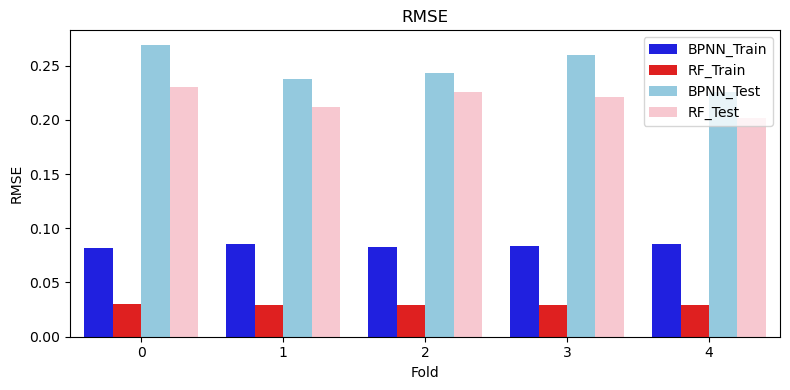

In [34]:
# RMSE-plot
metnames = ["RMSE"]

# Preparing data for seaborn
data = []
folds = np.arange(len(rf_cv_results))

for i in range(1):
    mtrain = ann_rmse_train[:, :].mean(axis=1)
    mtest = ann_rmse_test[:, :,].mean(axis=1)
    mtrainrf = rf_rmse_train[:, :].mean(axis=1)
    mtestrf = rf_rmse_test[:, :,].mean(axis=1)
    
    for fold in folds:
        data.append([fold, mtrain[fold], 'BPNN_Train', metnames[i]])
        data.append([fold, mtrainrf[fold], 'RF_Train', metnames[i]])
        data.append([fold, mtest[fold], 'BPNN_Test', metnames[i]])
        data.append([fold, mtestrf[fold], 'RF_Test', metnames[i]])

df = pd.DataFrame(data, columns=['Fold', 'Value', 'Dataset', 'Metric'])

# Plotting with seaborn
fig = plt.figure(figsize=[8, 4])
palette = {"BPNN_Train": "blue", "BPNN_Test": "skyblue", 
           "RF_Train": "red", "RF_Test": "pink"}

ax = fig.add_subplot(1,1,1)
sns.barplot(x='Fold', y='Value', hue='Dataset', data=df[df['Metric'] == metnames[i]], ax=ax, palette=palette)
ax.set_title(metnames[0])
ax.set_xlabel('Fold')
ax.set_ylabel(metnames[0])
ax.legend()

plt.tight_layout()
plt.show()

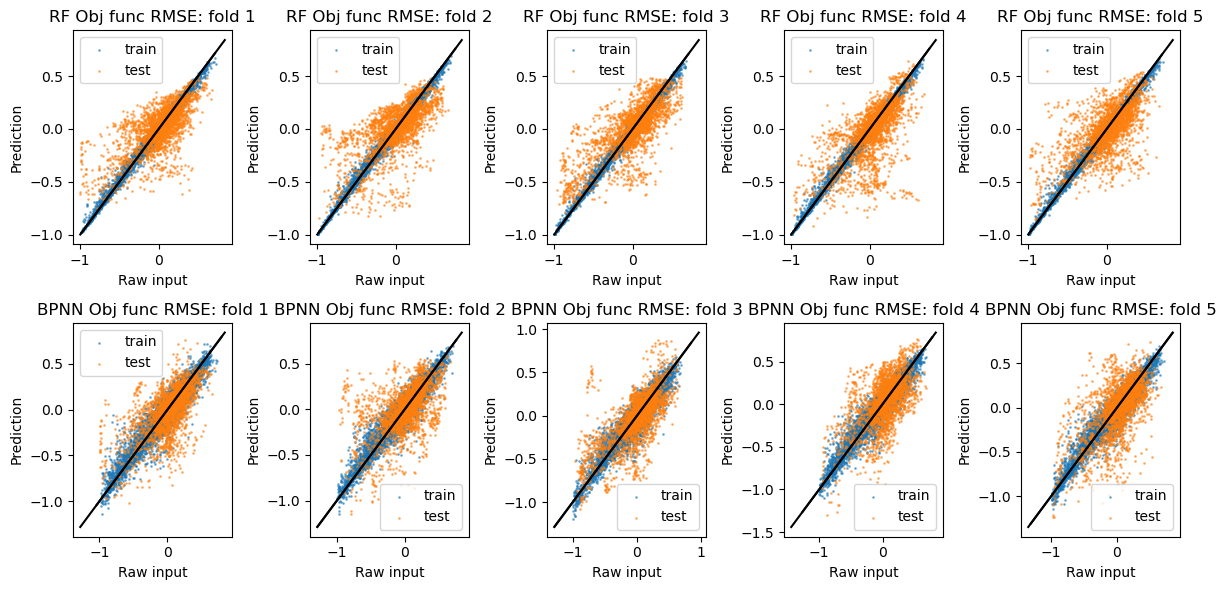

In [42]:
# one obj funcs scatter plots of CV results

cvplot = [rf_cv_results, ann_cv_results]
tp = ['RF', 'BPNN']

fig = plt.figure(figsize=(12, 6))

step=20
markersize=1
flag = 1

for j in range(2):
    for i in range(nfold):
    
        fig.add_subplot(2, 5, flag)

        for t in ['train', 'test']:
            d1, d2 = cvplot[j][i][f'y_{t}'][:,0], cvplot[j][i][f'y_{t}_pred'][:,0]
            
            plt.scatter(d1[::step], d2[::step],markersize,label=t, alpha=0.5)
            lim1, lim2 = min(min(d1), min(d2)), max(max(d1), max(d2))
            plt.plot([lim1, lim2], [lim1, lim2], 'k')
            plt.title(f'{tp[j]} Obj func RMSE: fold {i+1}')
        
        plt.xlabel('Raw input')
        plt.ylabel('Prediction')
        plt.legend()
        
        flag = flag + 1


plt.tight_layout()
plt.show()
